### 2.0 Loading Library Dependencies

In [2]:
# Run this before continuing
install.packages("ggcorrplot")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
# run this before continuing
library(tidyverse)   #Allows to transform and present data
library(broom)       #Allows for hypothesis testing
library(ggplot2)     #Allows to present data vectors accordingly
library(gridExtra)   #Allows to organize presented data graphs
library(grid)        #Allows to organize presented data graphs
library(infer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




### 2.2 Reading and Wrangling Rice Data Set into R

In [4]:
#Reading original Rice data set from Github repository to R
url<- "https://raw.githubusercontent.com/yun-sky/stat-201-project/main/Rice_Cammeo_Osmancik.arff"
rice_data <- read.csv(url, header=FALSE, comment.char = "@", skip = 4) |>
                      type.convert(as.is= TRUE) #Converting character data type into double data type                  

#Assigning correct column names
colnames(rice_data) <- c("area", "perimeter", "major_axis_length", "minor_axis_length", "eccentricity", 
                            "convex_area", "extent", "class")


### 2.3 Exploratory Data Analysis

In [5]:
#Given Correlation plot we can select our variables from the data set
cleaned_rice_data <- rice_data|>
                     select(perimeter, major_axis_length, class)
head(cleaned_rice_data)

,perimeter,major_axis_length,class
,<dbl>,<dbl>,<chr>
1,525.579,229.7499,Cammeo
2,494.311,206.0201,Cammeo
3,501.122,214.1068,Cammeo
4,458.343,193.3374,Cammeo
5,507.167,211.7434,Cammeo
6,477.016,200.0531,Cammeo


In [6]:
# Calculating the mean and standard deviation for each selected class
summary_rice <- cleaned_rice_data |>
    group_by(class) |>
    summarize(mean_perimeter = mean(perimeter), mean_mal = mean(major_axis_length), 
              sd_perimeter = sd(perimeter), sd_mal = sd(major_axis_length))
summary_rice

class,mean_perimeter,mean_mal,sd_perimeter,sd_mal
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Cammeo,487.4389,205.4786,22.18152,10.333854
Osmancik,429.4155,176.2878,20.15439,9.362405


In [7]:
# Calculating the parameters of interest: difference in means and difference in standard deivation for the perimeter
# major axis length
rice_estimates <- summary_rice %>%
    pivot_wider(names_from = class, values_from = c(mean_perimeter, mean_mal, sd_perimeter, sd_mal)) |>
    mutate(mean_diff_perimeter = mean_perimeter_Cammeo - mean_perimeter_Osmancik,
           mean_diff_mal       = mean_mal_Cammeo - mean_mal_Osmancik,
           sd_diff_perimeter   = sd_perimeter_Cammeo - sd_perimeter_Osmancik,
           sd_diff_mal         = sd_mal_Cammeo - sd_mal_Osmancik) |>
    select(mean_diff_perimeter, mean_diff_mal, sd_diff_perimeter, sd_diff_mal)
head(rice_estimates)

mean_diff_perimeter,mean_diff_mal,sd_diff_perimeter,sd_diff_mal
<dbl>,<dbl>,<dbl>,<dbl>
58.02344,29.19083,2.027124,0.9714491


### Hypothesis Testing Difference in Mean Perimeter
Results are looking suspiciously good (look at visualized distribution). I assume that this is a result of using a large sample size. I used a significance level of 0.01. Was unsure if we were gonna do the t-distribution so I included it just in case if we need it. 

#### Bootstrapping Method

In [108]:
# Preliminary Calculations: separate the data by class and 
# count the number of observations in each sample
cammeo_sample <- filter(cleaned_rice_data, class == "Cammeo")
osmancik_sample <- filter(cleaned_rice_data, class == "Osmancik")
n_cammeo <- nrow(cammeo_sample) 
n_osmancik <- nrow(osmancik_sample)

In [109]:
# hypothesis testing using bootstrapping
set.seed(2023)

# Generate the bootstrap distribution for difference in  means
bootstrap_dist_perimeter <- cleaned_rice_data %>%
    specify(formula = perimeter ~ class) %>%
    hypothesize(null = "independence") %>%
    generate(type = "permute", reps = 1000) %>%
    calculate(stat = "diff in means", order = c("Cammeo", "Osmancik"))

Warning message in min(diff(unique_loc)):
“no non-missing arguments to min; returning Inf”


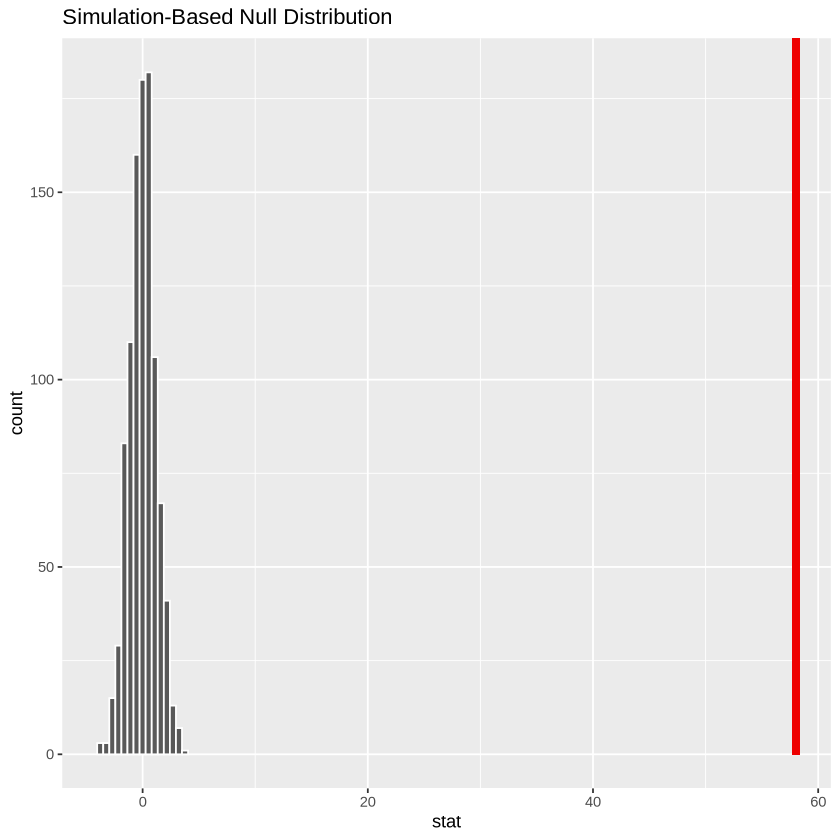

In [110]:
# Visualize Bootstrap Distribution
bootstrap_perimeter_hist <- visualize(bootstrap_dist_perimeter) +
    shade_p_value(test_stat_mean_perimeter, direction = "right")
bootstrap_perimeter_hist
# RESULTS: we reject the null hypo

#### t-distribution Method: using `pt()`

In [78]:
# MEAN PERIMETER: Conduct the t-test using the pt() function
# test if test-statistic is within the rejection region
p_value_dim_perimeter <- pt(test_stat_mean_perimeter, df = n_cammeo + n_osmancik - 2, lower.tail = FALSE)

#### t-distribution Method: using `t.test()`

In [98]:
# MEAN PERIMETER: Conduct t-test using t.test() function
t_results_mean_perimeter <- tidy(t.test(mu = 0,
                                       x = cammeo_sample$perimeter,
                                       y = osmancik_sample$perimeter, 
                                       alternative = "greater",
                                       conf.level = 0.99)) %>%
                            rename(diff_in_mean_perimeter = estimate,
                                   cammeo_mean = estimate1,
                                   osmancik_mean = estimate2)
t_results_mean_perimeter
# RESULTS: The p-value is zero, so we reject the null-hypothesis. This suggests that
#          the true cammeo perimeter mean is greater than the true osmancik perimeter mean

diff_in_mean_perimeter,cammeo_mean,osmancik_mean,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
58.02344,487.4389,429.4155,83.04477,0,3316.182,56.39723,Inf,Welch Two Sample t-test,greater


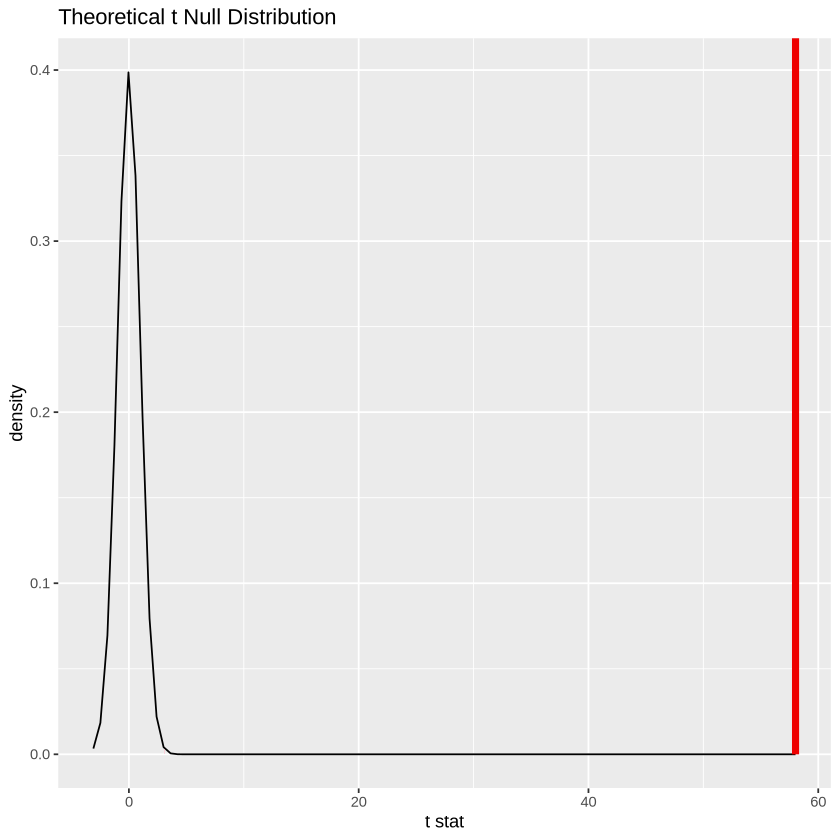

In [100]:
t_null_dist <- cleaned_rice_data %>%
    specify(formula = perimeter ~ class) %>%
    assume(distribution = "t")
visualize(t_null_dist) + shade_p_value(test_stat_mean_perimeter, direction = "right")

## 3 Methods: Plan


As our dataset was collected from a reputable source and the analysis done was peer-reviewed, we feel confident in our initial findings. Although our visualizations allow us to draw inferences about the relationships between our predictors and response, they do not prove anything. To do so, we hypothesize below and later test those claims:

**Difference in means**
- $H_0: \mu_1 - \mu_2 = 0$
- $H_A: \mu_1 - \mu_2  > 0$

Where $\mu_1$ and $\mu_2$ are the mean of the variables of interest of Cammeo and Osmanik rice respectively.

**Difference in standard deviation**
- $H_0: \sigma_1 - \sigma_2 = 0$
- $H_A: \sigma_1 - \sigma_2 \neq  0$

Where $\sigma_1$ and $\sigma_2$ is the standard deviation of Cammeo and Osmanik rice respectively.


The above hypothesis tests will be performed on both `major_axis_length` and `perimeter`. We will conduct bootstrapping and CLT to make conclusions about our hypotheses. From that, 95% confidence intervals will be drawn for the difference in means, and the analysis will conclude with a comparison of both methods.

We can expect to reject our null for all four sets of hypothesis tests (refer to figure 2a, 2b). Due to the rejection of the null, we can also expect our 95% confidence intervals for difference in means to not contain 0. 

These conclusions can mean that classification between Cammeo and Osmancik would be much easier given the two predictors we are interested in. These findings could be important for business in the agricultural sector. It is also within our interest to explore our variables, `perimeter` and `major_axis_length` further to see which farming techniques could optimize the rice growth and in turn increase profits.